In [60]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
pd.options.mode.chained_assignment = None
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from pmdarima.arima.utils import nsdiffs
from sklearn.model_selection import train_test_split

Data Processing

C:\Users\LLR User\AppData\Local\Temp\ipykernel_8364\2374362387.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ice.interpolate(inplace=True)


<Axes: xlabel='date'>

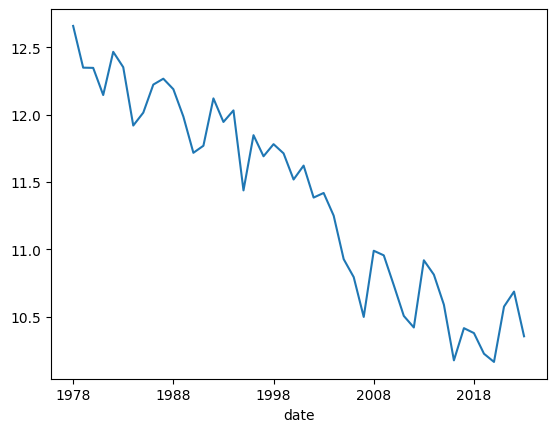

In [61]:
csv = [pd.read_csv(f"./data/N_{str(i).zfill(2)}_extent_v3.0.csv") for i in range(1, 13)]
ice = pd.concat(csv, axis=0, ignore_index=True)
columns = ice.columns
name = [col.strip() for col in columns]
ice.columns = name
ice['extent'] = np.where(abs(ice['extent']) > 20, np.nan, ice['extent'])
ice['area'] = np.where(abs(ice['area']) > 20, np.nan, ice['area'])
ice.interpolate(inplace=True)

# Monthly data
monthly_data = ice.groupby(['year', 'mo'])['extent'].mean().reset_index()
monthly_data.rename(columns={'mo': 'month'}, inplace=True)
monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))
monthly_data.set_index('date', inplace=True)
monthly_data.index = monthly_data.index.strftime('%Y-%m')
monthly_data.drop(['year', 'month'], axis=1, inplace=True)

#yearly data
yearly_mean = ice.groupby('year')[['extent']].mean().reset_index()
yearly_mean['date'] = pd.to_datetime(yearly_mean[['year']].assign(month=1, day=1))
yearly_mean.set_index('date', inplace=True)
yearly_mean.index = yearly_mean.index.strftime('%Y')
yearly_mean.drop(['year'], axis=1, inplace=True)


yearly_mean['extent'].plot()

### LinearRegression and AR,MA definitions

In [62]:
import numpy as np

class LinearRegression:
    def __init__(self, lr = 0.001, n_iters = 30000):
        
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        num_samples, num_features = X.shape     
        self.weights = np.random.rand(num_features,1)  
        self.bias = 0
        
        for i in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias
            
            dw = (1 / num_samples) * np.dot(X.T, y_pred - y)
            db = (1 / num_samples) * np.sum(y_pred - y)
            
            self.weights = self.weights - self.lr * dw
            self.bias = self.bias - self.lr * db
            
            
        
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias




In [63]:
def auto_regressive_model(order, data):


    for i in range(1, order + 1):
        data[f'Shifted_values_{i}'] = data['extent'].shift(i)

    train_size = int(0.8 * data.shape[0])
    df_train = pd.DataFrame(data[0:train_size])
    df_test = pd.DataFrame(data[train_size:])

    df_train_2 = df_train.dropna()
    X_train = df_train_2.iloc[:, 1:].values.reshape(-1, order)
    y_train = df_train_2.iloc[:, 0].values.reshape(-1, 1)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    theta = lr.weights
    intercept = lr.bias

    df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept

    X_test = df_test.iloc[:, 1:].values.reshape(-1, order)
    df_test['Predicted_Values'] = X_test.dot(theta) + intercept

    RMSE = np.sqrt(mean_squared_error(df_test['extent'], df_test['Predicted_Values']))
        
    MAE = mean_absolute_error(df_test['extent'], df_test['Predicted_Values'])
    R2 = r2_score(df_test['extent'], df_test['Predicted_Values'])

    print(f"The RMSE is: {RMSE}, MAE is: {MAE}, R2 score is: {R2}, Order of AR model: {order}")

    
    

    return [df_train_2, df_test, theta, intercept, RMSE]


In [64]:
def moving_average_model(order, residuals):
    for i in range(1, order + 1):
        residuals[f'Shifted_values_{i}'] = residuals['Residuals'].shift(i)

    train_size = int(0.8 * residuals.shape[0])

    res_train = pd.DataFrame(residuals[0:train_size])
    res_test = pd.DataFrame(residuals[train_size:])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:, 1:].values.reshape(-1, order)
    y_train = res_train_2.iloc[:, 0].values.reshape(-1, 1)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    theta = lr.weights
    intercept = lr.bias
    res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept

    X_test = res_test.iloc[:, 1:].values.reshape(-1, order)
    res_test['Predicted_Values'] = X_test.dot(theta) + intercept

    from sklearn.metrics import mean_squared_error
    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

    print("The RMSE is:", RMSE, ", Value of q:", order)
    
    
    
    return [res_train_2, res_test, theta, intercept, RMSE]


Will check the required differencing to make the data stationary

In [65]:
diff_trend = ndiffs(yearly_mean)
print(diff_trend)

1


<Axes: xlabel='date'>

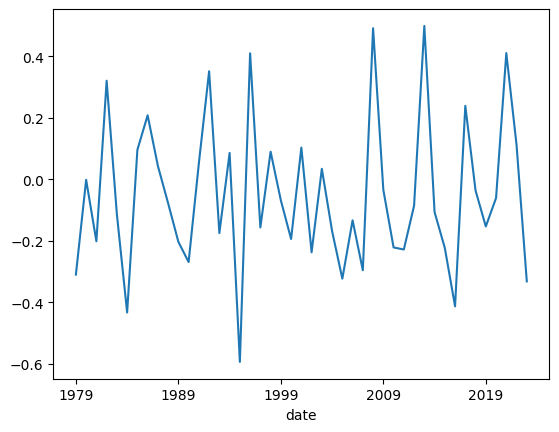

In [66]:
stationary_year = yearly_mean.diff(1).dropna()
stationary_year['extent'].plot()

In [67]:
[df_train,df_test,theta,intercept,RMSE] = auto_regressive_model(4,stationary_year)

The RMSE is: 0.24970152585473862, MAE is: 0.21581855933975735, R2 score is: 0.0236230496018639, Order of AR model: 4


<Axes: ylabel='Density'>

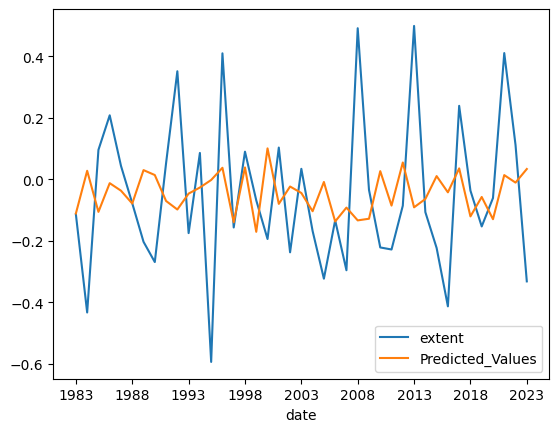

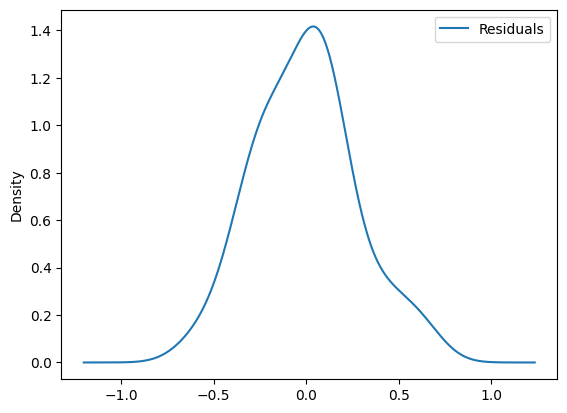

In [68]:
output_data = pd.concat([df_train,df_test])
output_data[['extent','Predicted_Values']].plot()
residuals = pd.DataFrame()
residuals['Residuals'] = output_data.extent - output_data.Predicted_Values
residuals.plot(kind='kde')

The RMSE is: 0.22425780897977765 , Value of q: 3


<Axes: xlabel='date'>

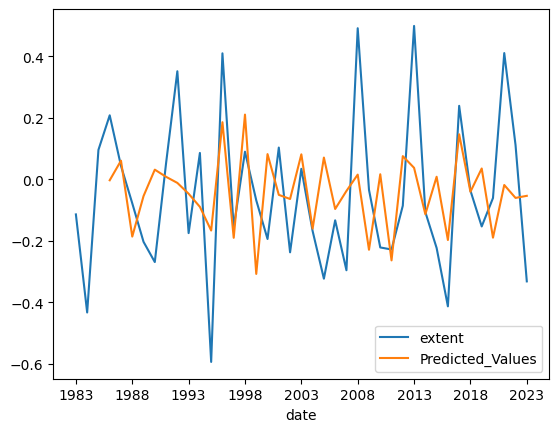

In [69]:
[res_train,res_test,theta,intercept,RMSE] = moving_average_model(3,residuals)
output_residuals = pd.concat([res_train,res_test])
output_data['Predicted_Values'] += output_residuals['Predicted_Values']
output_data[['extent','Predicted_Values']].plot()

In [70]:
original_series = output_data['Predicted_Values'] + yearly_mean['extent'].shift(1)
original_series = original_series.dropna()
original_series_df = pd.DataFrame(original_series, columns=['extent'])

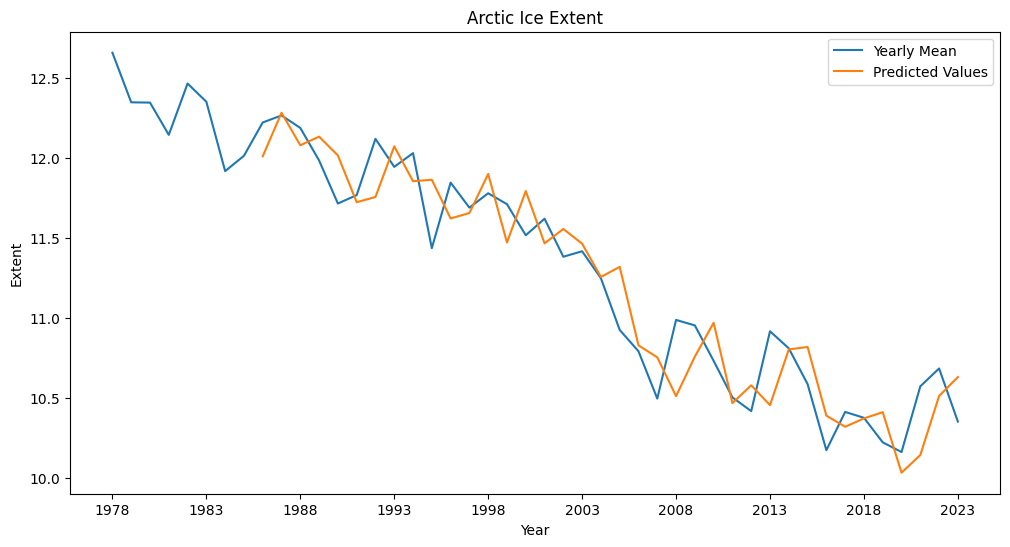

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(yearly_mean, label='Yearly Mean')
plt.plot(original_series, label='Predicted Values')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Extent')
plt.title('Arctic Ice Extent')
plt.xticks(np.arange(0, len(yearly_mean), 5), yearly_mean.index[::5])

plt.show()


In [72]:
original_series_df = pd.DataFrame(original_series, columns=['extent'])





In [73]:
merged_df = original_series_df.merge(yearly_mean[['extent']], left_index=True, right_index=True)
merged_df = merged_df[['extent_x', 'extent_y']]
merged_df.columns = ['Predicted_Values', 'Actual_Values']



In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming you have the actual values in y_true and predicted values in y_pred
mse = mean_squared_error(merged_df['Predicted_Values'], merged_df['Actual_Values'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(merged_df['Predicted_Values'], merged_df['Actual_Values'])
r2 = r2_score(merged_df['Predicted_Values'], merged_df['Actual_Values'])


print('ARIMA Metrics')
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Score: {r2}")


ARIMA Metrics
Root Mean Squared Error (RMSE): 0.2309541179595145
Mean Absolute Error (MAE): 0.18965850624011535
R-squared (R2) Score: 0.8792263450503744


## SARIMA

In [75]:
csv = [pd.read_csv(f"./data/N_{str(i).zfill(2)}_extent_v3.0.csv") for i in range(1, 13)]
ice = pd.concat(csv, axis=0, ignore_index=True)
columns = ice.columns
name = [col.strip() for col in columns]
ice.columns = name
ice['extent'] = np.where(abs(ice['extent']) > 20 , np.nan, ice['extent'])
ice['area'] = np.where(abs(ice['area']) > 20, np.nan, ice['area'])
ice.interpolate(inplace=True)

monthly_data = ice.groupby(['year', 'mo'])['extent'].mean().reset_index()
monthly_data['date'] = pd.to_datetime(monthly_data.assign(day=1, month=monthly_data['mo'])[['year', 'month', 'day']])
monthly_data.drop(['year', 'mo'], axis=1, inplace=True)
monthly_data.head()
temp_data = monthly_data.set_index('date')

C:\Users\LLR User\AppData\Local\Temp\ipykernel_8364\2857382309.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ice.interpolate(inplace=True)


We will look at the Auto-correlation and Partial-Auto-correlation plots to gain insights from the data

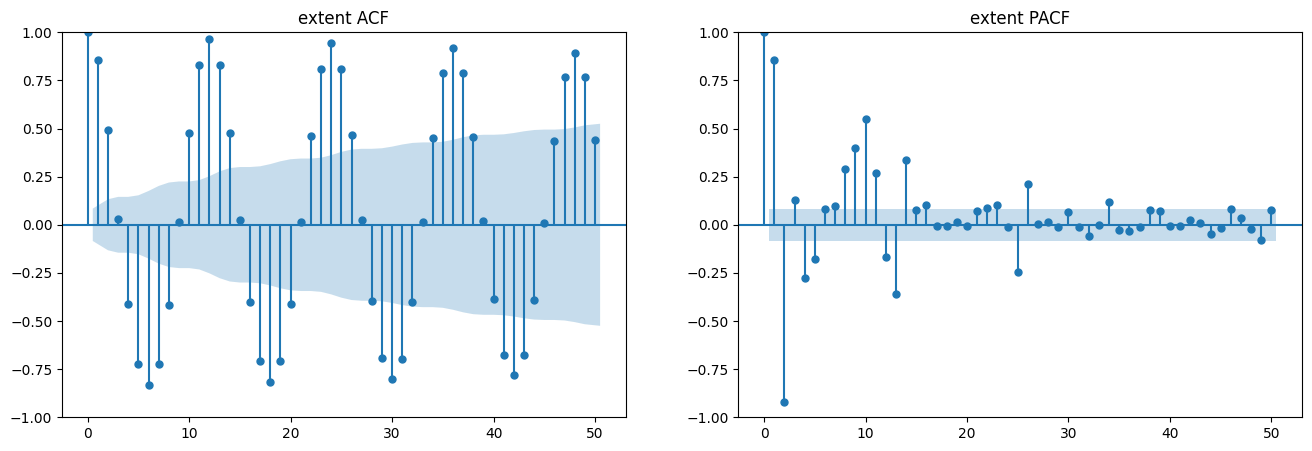

In [76]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(temp_data, title="extent ACF", lags=50, ax=ax1)
sm.graphics.tsa.plot_pacf(temp_data, title="extent PACF", lags=50, ax=ax2)
plt.show()

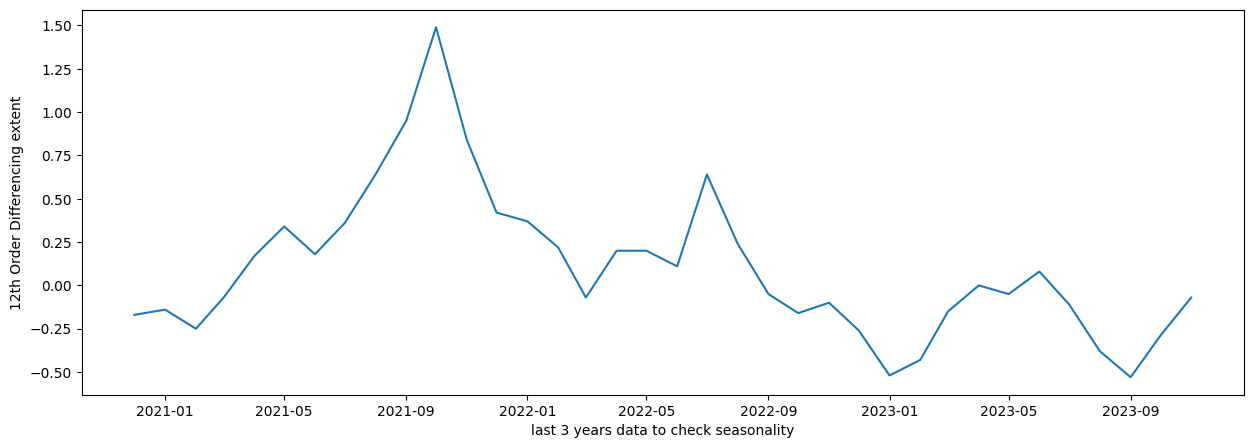

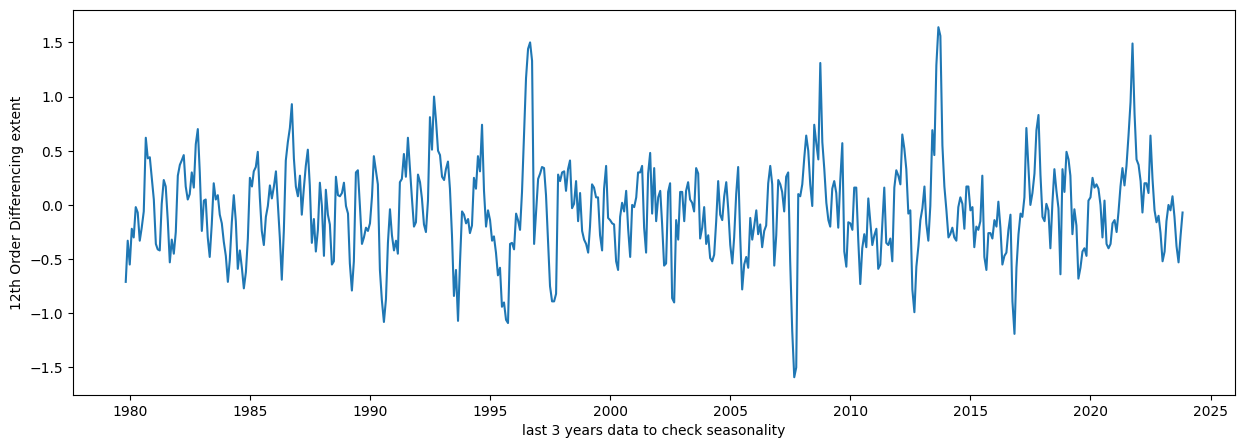

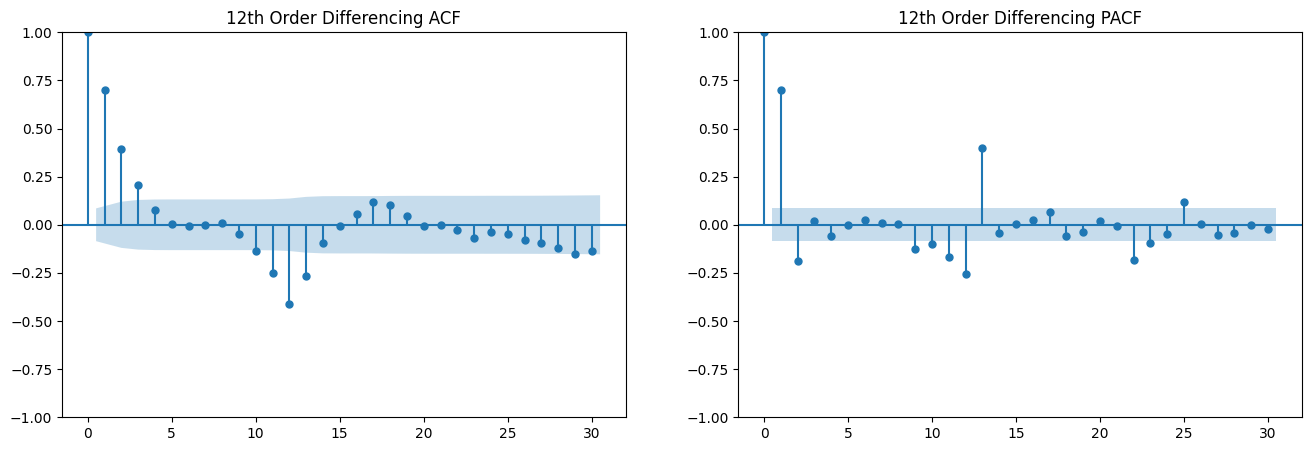

In [77]:
differenced_data = temp_data.diff(12).dropna()

plt.figure(figsize=(15, 5))
plt.plot(differenced_data[-36:])
plt.xlabel("last 3 years data to check seasonality")
plt.ylabel("12th Order Differencing extent")

plt.figure(figsize=(15, 5))
plt.plot(differenced_data)
plt.xlabel("last 3 years data to check seasonality")
plt.ylabel("12th Order Differencing extent")

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(differenced_data, title="12th Order Differencing ACF", lags=30, ax=ax1)
sm.graphics.tsa.plot_pacf(differenced_data, title="12th Order Differencing PACF", lags=30, ax=ax2)
plt.show()

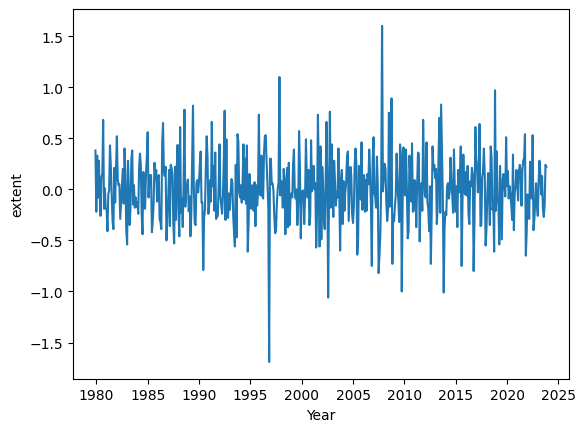

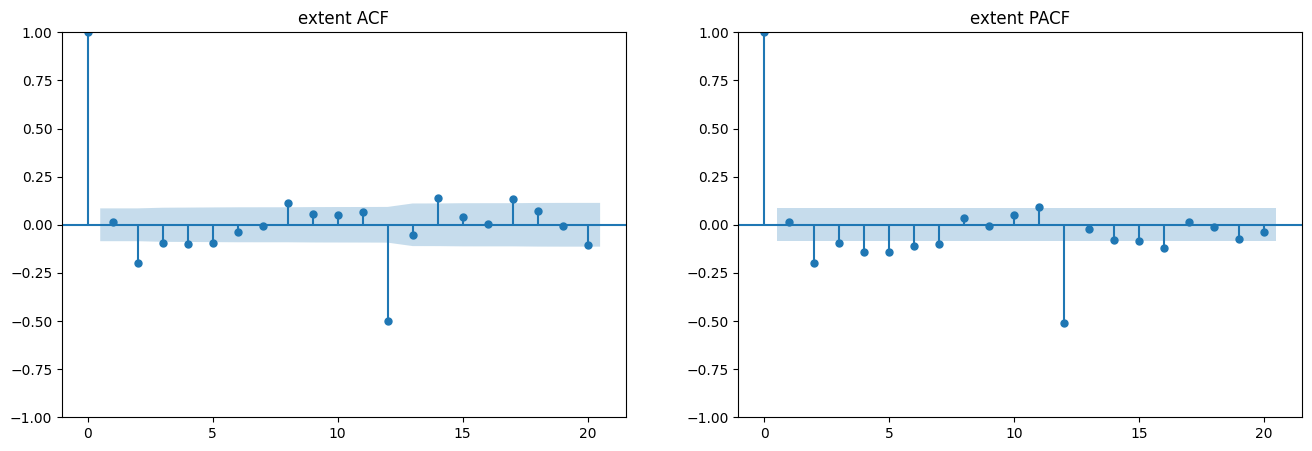

In [78]:
stationary_series = differenced_data.diff().dropna()
plt.plot(stationary_series)
plt.xlabel("Year")
plt.ylabel("extent")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(stationary_series, title="extent ACF", lags=20, ax=ax1)
sm.graphics.tsa.plot_pacf(stationary_series, title="extent PACF", lags=20, ax=ax2)
plt.show()

From the plots, we can see that 1 differencing for both seasonal and non-seasonal makes it stationary as we have both trend and seasonality in our data! Let's confirm it! 

In [79]:
diff_trend = ndiffs(temp_data)
diff_season = nsdiffs(temp_data,m=12)

print(diff_trend)
print(diff_season)

1
1


We will split the data

In [80]:
x = temp_data.index.to_numpy()
y = temp_data['extent']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,shuffle=False)


We will fit the model on train set and forecast on the test set

c:\Users\LLR User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LLR User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LLR User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


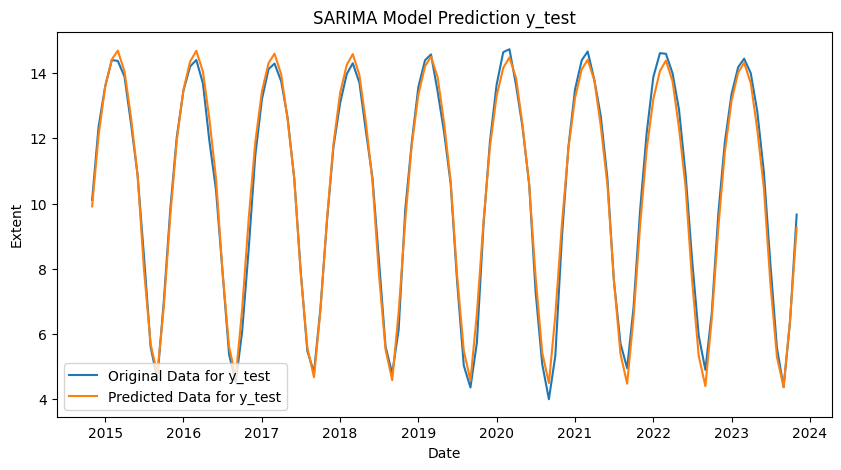

In [81]:

model = sm.tsa.SARIMAX(y_train, order=(3, 1, 3), seasonal_order=(2, 1, 2, 12))
model_fit = model.fit()


forecast = model_fit.get_forecast(steps=len(y_test))
predicted_values = forecast.predicted_mean

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label='Original Data for y_test')
plt.plot(y_test.index, predicted_values, label='Predicted Data for y_test')
plt.xlabel('Date')
plt.ylabel('Extent')
plt.title('SARIMA Model Prediction y_test')
plt.legend()



Metrics for the test data

In [82]:
mse = mean_squared_error(y_test, forecast.predicted_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast.predicted_mean)
r2 = r2_score(y_test, forecast.predicted_mean)


print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

R-squared: 0.9892147855080403
Mean Squared Error: 0.12629542597063342
Root Mean Squared Error: 0.35538067754259434
Mean Absolute Error: 0.28332762600329175


We will now forecast till we get the ice-free year

In [83]:
forecast = model_fit.get_forecast(steps=1200)
predicted_values = forecast.predicted_mean
np.random.seed(123)  
noise = np.random.normal(0, 0.3, len(predicted_values))
predicted_values_random= predicted_values + noise

year_x = predicted_values_random[predicted_values_random <= 0].index[0]
print(f'The ice extent becomes zero at year {year_x}')

The ice extent becomes zero at year 2107-09-01 00:00:00


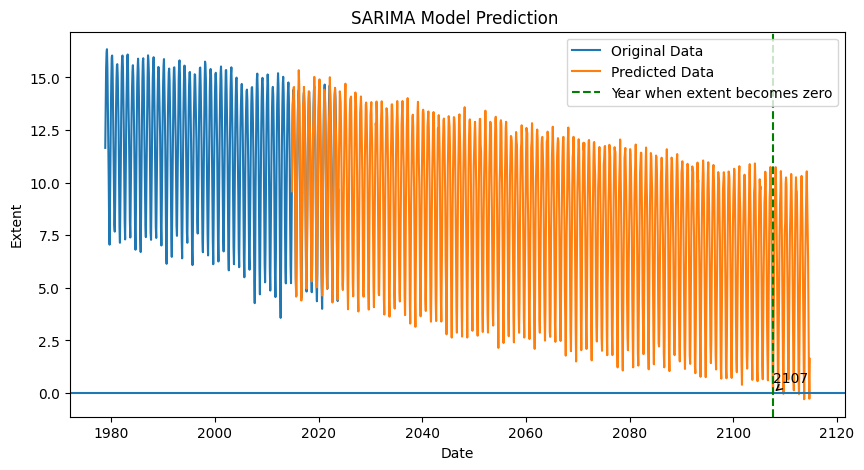

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(temp_data.index, temp_data.values, label='Original Data')
plt.plot(predicted_values.index, predicted_values_random, label='Predicted Data')
plt.axhline(0)
plt.axvline(year_x, color='g', linestyle='--', label='Year when extent becomes zero')
plt.xlabel('Date')
plt.ylabel('Extent')
plt.title('SARIMA Model Prediction ')
plt.legend()
plt.annotate('2107', xy=(year_x, 0), xytext=(year_x, 0.5), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()